In [1]:
! pip install kaggle

In [31]:
# Import libraries
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle (1).json"

In [5]:
!kaggle datasets download -d stealthtechnologies/traffic-time-series-dataset

Dataset URL: https://www.kaggle.com/datasets/stealthtechnologies/traffic-time-series-dataset
License(s): apache-2.0
  0% 0.00/47.3k [00:00<?, ?B/s]
100% 47.3k/47.3k [00:00<00:00, 65.9MB/s]


In [6]:
with ZipFile("traffic-time-series-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("traffic_data")

In [7]:
# load
data = pd.read_csv('/content/traffic_data/traffic_dataset_with_trend.csv')

In [8]:
# Exploratory Data Analysis (EDA)
data.head()

,Timestamp,Weather,Events,Traffic Volume
0,2023-01-01 00:00:00,Cloudy,False,803.0
1,2023-01-01 01:00:00,Clear,False,861.0
2,2023-01-01 02:00:00,Clear,False,582.0
3,2023-01-01 03:00:00,Cloudy,False,236.0
4,2023-01-01 04:00:00,Cloudy,False,569.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8736 entries, 0 to 8735
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       8736 non-null   object 
 1   Weather         8736 non-null   object 
 2   Events          8736 non-null   bool   
 3   Traffic Volume  8736 non-null   float64
dtypes: bool(1), float64(1), object(2)
memory usage: 213.4+ KB


In [12]:
data.describe()

,Traffic Volume
count,8736.000000
mean,1281.395833
std,727.291462
min,118.000000
25%,893.000000
50%,1123.000000
75%,1415.000000
max,6465.000000


In [33]:
data.isna().sum()

,0
Events,0
Traffic Volume,0
Hour,0
Dayofweek,0
Month,0
Day,0
DayOfWeek,0
WeekOfYear,0
IsWeekend,0
Weather_Cloudy,0


In [34]:
data['Events'].unique()

array([False,  True])

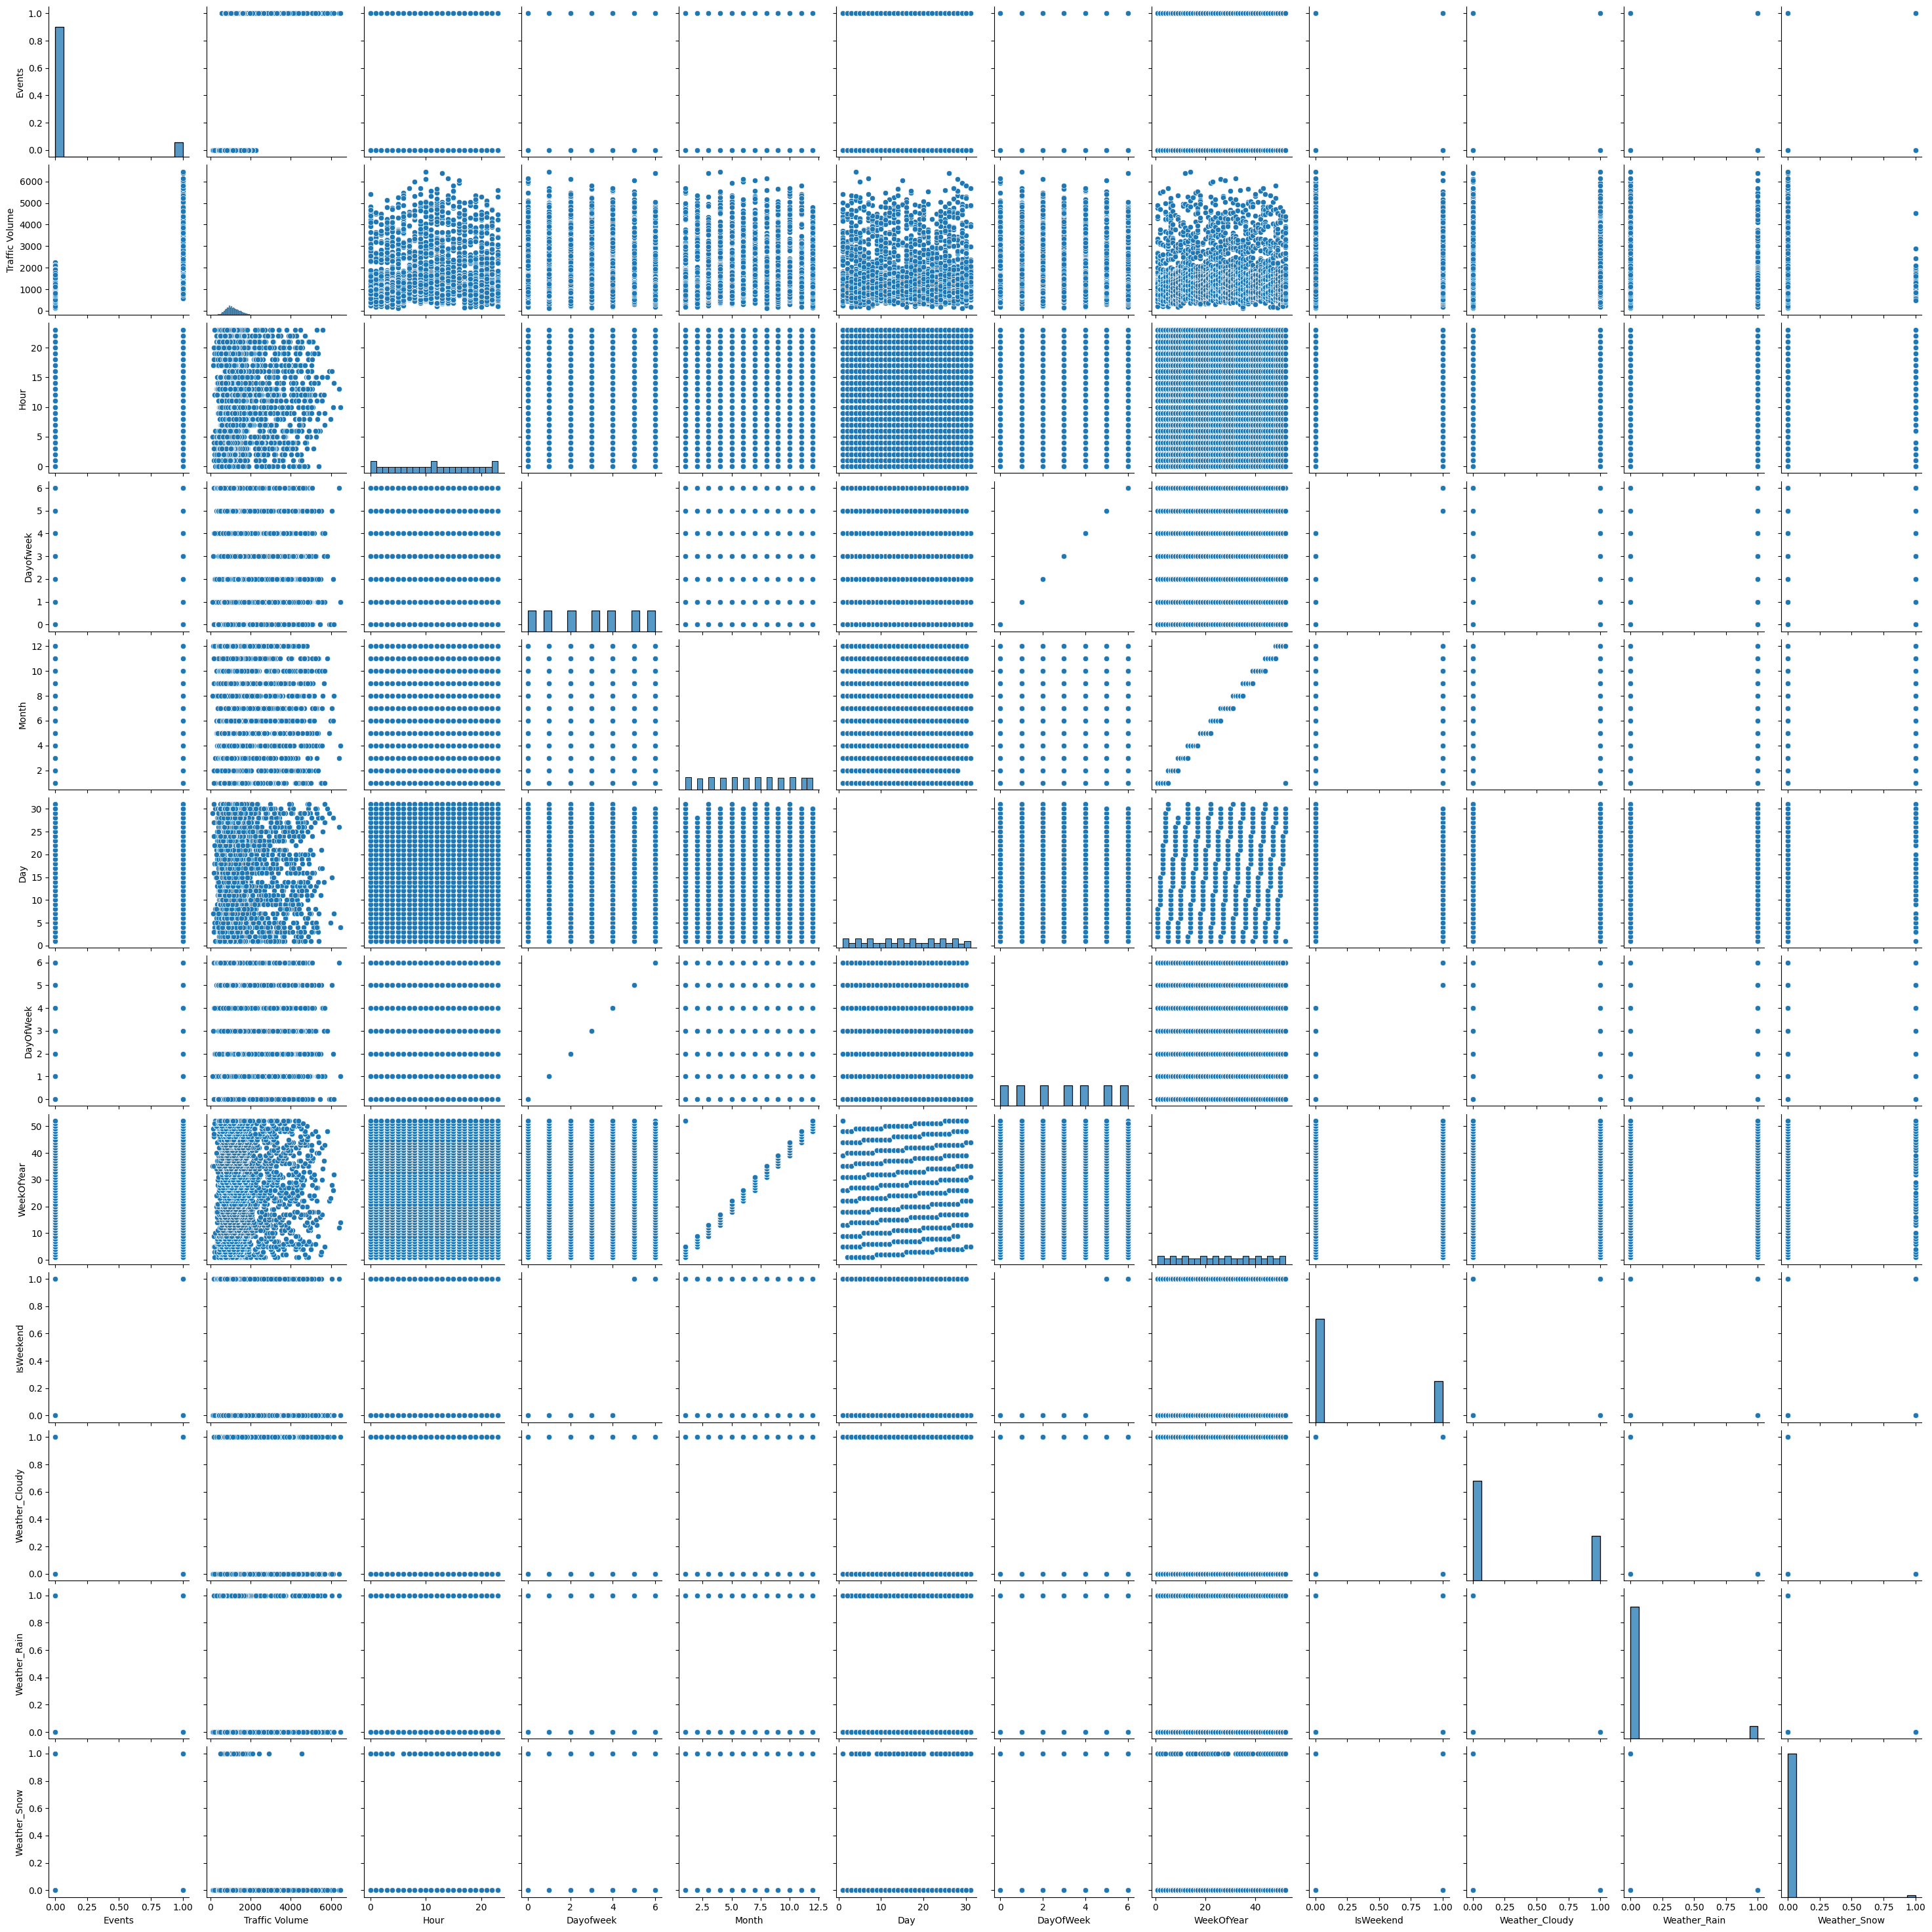

In [35]:
sns.pairplot(data)

<Axes: >

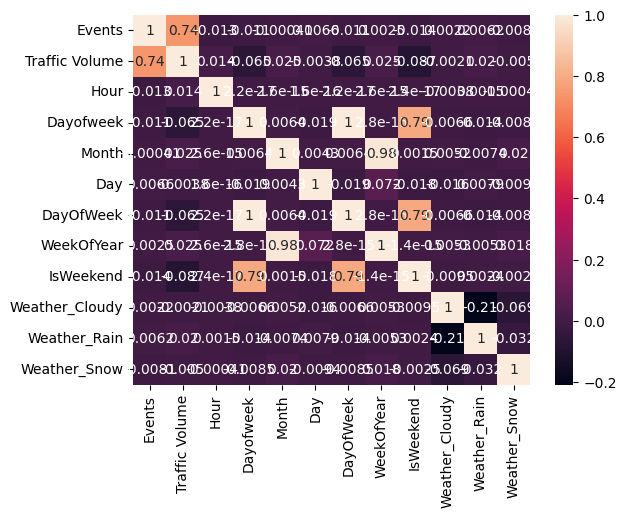

In [36]:
sns.heatmap(data.corr(), annot=True)

In [14]:
# peeprocessing
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [15]:
data.set_index('Timestamp', inplace = True)

In [17]:
data['Hour'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['Day'] = data.index.day
data['WeekOfYear'] = data.index.isocalendar().week
data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)

In [20]:
data

,Events,Traffic Volume,Hour,Dayofweek,Month,Day,DayOfWeek,WeekOfYear,IsWeekend,Weather_Cloudy,Weather_Rain,Weather_Snow
Timestamp,,,,,,,,,,,,
2023-01-01 00:00:00,False,803.0,0,6,1,1,6,52,1,True,False,False
2023-01-01 01:00:00,False,861.0,1,6,1,1,6,52,1,False,False,False
2023-01-01 02:00:00,False,582.0,2,6,1,1,6,52,1,False,False,False
2023-01-01 03:00:00,False,236.0,3,6,1,1,6,52,1,True,False,False
2023-01-01 04:00:00,False,569.0,4,6,1,1,6,52,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 19:00:00,False,1118.0,19,5,12,30,5,52,1,True,False,False
2023-12-30 20:00:00,False,1681.0,20,5,12,30,5,52,1,False,False,False
2023-12-30 21:00:00,False,833.0,21,5,12,30,5,52,1,True,False,False


In [19]:
#Categorical Encoding
data = pd.get_dummies(data, columns=['Weather'], drop_first = True)

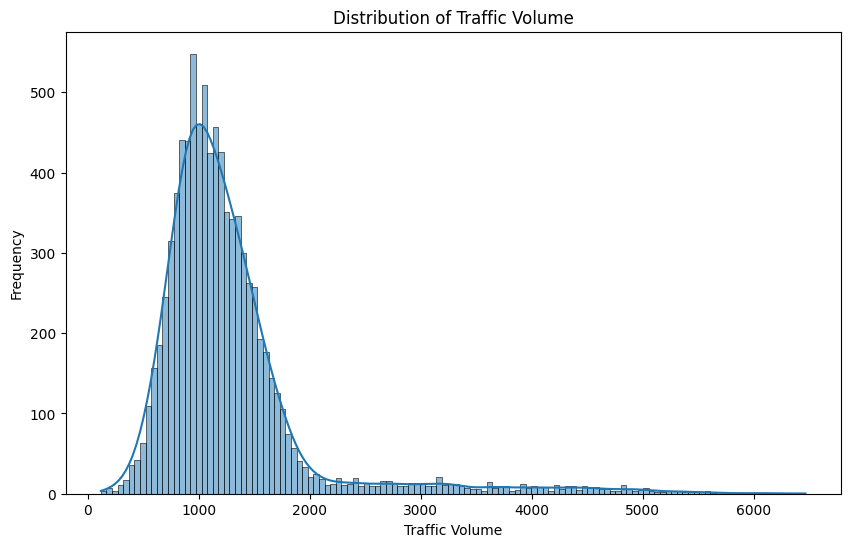

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Traffic Volume'], kde=True)
plt.title('Distribution of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()

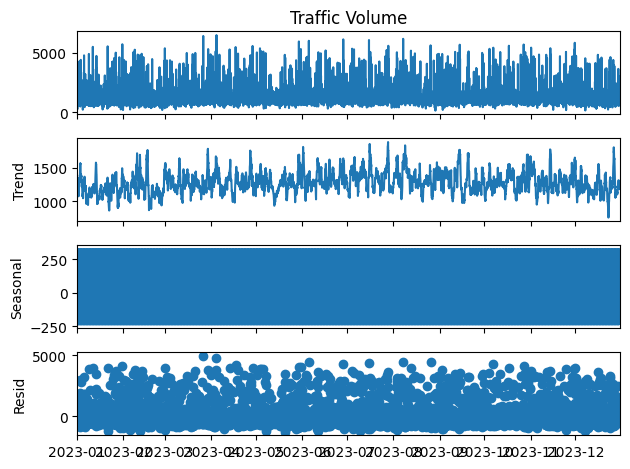

In [22]:
decomposition = seasonal_decompose(data['Traffic Volume'], model='additive', period=24)

decomposition.plot()
plt.show()

In [24]:
# Model Development and Training
X = data.drop(columns=['Traffic Volume'])
y = data['Traffic Volume']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2142826.2500
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2129526.5000
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2124657.5000
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2111849.7500
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1947852.6250
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1998577.6250
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2085021.6250
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2010837.1250
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1888124.2500
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1896035.0000


In [32]:
# Model Evaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Squared Error: 1902636.1543372169
